<a href="https://colab.research.google.com/github/AparnaMadva/NLP-Course-Tutorials/blob/main/Skipgram%26CBOW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Word2Vec : Skip-Gram and CBOW

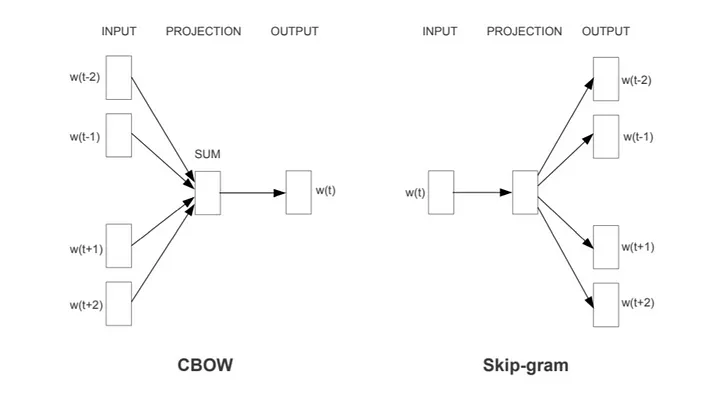

[Figure](https://arxiv.org/pdf/1309.4168v1.pdf): Architecture of Skip-gram and CBOW models

In [ ]:
import nltk
import numpy as np
import pandas as pd
import re

from string import punctuation
import matplotlib.pyplot as plt

#plt.figure(figsize = (4,4))

## SkipGram model

#### Build corpus vocabulary

In [ ]:
from nltk.corpus import gutenberg

nltk.download('gutenberg')
nltk.download('punkt')
nltk.download('stopwords')

stop_words = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
nltk.corpus.gutenberg.fileids()

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

In [ ]:
bible = gutenberg.sents("shakespeare-hamlet.txt")
remove_terms = punctuation + '0123456789'
wpt = nltk.WordPunctTokenizer()

def normalize_document(doc):
  doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
  doc = doc.lower()
  doc = doc.strip()

  tokens = wpt.tokenize(doc)

  filtered_tokens = [token for token in tokens if token not in stop_words]

  doc = ' '.join(filtered_tokens)

  return doc

normalize_corpus = np.vectorize(normalize_document)

In [ ]:
norm_bible = [[word.lower() for word in sent if word not in remove_terms]
              for sent in bible]

norm_bible = [' '.join(tok_sent) for tok_sent in norm_bible]
norm_bible = filter(None, normalize_corpus(norm_bible))
norm_bible = [tok_sent for tok_sent in norm_bible if len(tok_sent.split()) > 2]

In [ ]:
from keras.preprocessing import text

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_bible)

word2id = tokenizer.word_index
id2word = {v:k for k, v in word2id.items()}
vocab_size = len(word2id) + 1
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)]
        for doc in norm_bible]

print('Vocabulary size:', vocab_size)
print('vocabulary sample:', list(word2id.items())[:5])

Vocabulary size: 12425
vocabulary sample: [('shall', 1), ('unto', 2), ('lord', 3), ('thou', 4), ('thy', 5)]


#### Generate skip-grams

In [ ]:
from keras.preprocessing.sequence import skipgrams

skip_grams = [skipgrams(wid, vocabulary_size=vocab_size, window_size=10)
              for wid in wids]
pairs, labels = skip_grams[0][0], skip_grams[0][1]

In [ ]:
for i in range(10):
  print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
      id2word[pairs[i][0]],pairs[i][0],
      id2word[pairs[i][1]], pairs[i][1],
      labels[i]))

(james (1154), hazelelponi (9665)) -> 0
(bible (5766), king (13)) -> 1
(james (1154), king (13)) -> 1
(bible (5766), tibni (6186)) -> 0
(king (13), james (1154)) -> 1
(bible (5766), judea (10109)) -> 0
(king (13), conditions (11565)) -> 0
(bible (5766), james (1154)) -> 1
(james (1154), persons (982)) -> 0
(james (1154), bible (5766)) -> 1


#### Build skip-gram architecture

In [ ]:
from keras.layers import *
from keras.layers.core import Dense, Reshape
from keras.layers import Embedding
from keras.models import Model,Sequential

In [ ]:
embed_size = 100
word_model = Sequential()
word_model.add(Embedding(vocab_size, embed_size,
                         embeddings_initializer='glorot_uniform',
                         input_length=1))
word_model.add(Reshape((embed_size, )))

context_model = Sequential()
context_model.add(Embedding(vocab_size, embed_size,
                            embeddings_initializer='glorot_uniform',
                            input_length=1))
context_model.add(Reshape((embed_size,)))

merged_output = add([word_model.output, context_model.output])

model_combined = Sequential()
model_combined.add(Dense(1,
                         kernel_initializer='glorot_uniform',
                         activation='sigmoid'))

In [ ]:
final_model = Model([word_model.input,context_model.input],
                    model_combined(merged_output)
                    )
final_model.compile(loss='mean_squared_error', optimizer='rmsprop')
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 embedding_input (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 embedding_1_input (InputLayer)  [(None, 1)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 100)       1242500     ['embedding_input[0][0]']        
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 100)       1242500     ['embedding_1_input[0][0]']      
                                                                                              

In [ ]:
# #visualisation
# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot


# SVG(model_to_dot(final_model,
#                  show_shapes=True,
#                  show_layer_names=False,
#                  rankdir='TB').create(prog='dot', format='svg'))

#### Train model

In [ ]:
for epoch in range(1,2):
  loss = 0
  for i,elem in enumerate(skip_grams):
    pair_first = np.array(list(zip(*elem[0]))[0],
                          dtype='int32')
    pair_second = np.array(list(zip(*elem[0]))[1],
                           dtype='int32')
    labels = np.array(elem[1], dtype='int32')
    X = [pair_first, pair_second]
    Y = labels
    if i%10000 == 0:
      print('Processed {} (skip_first, skip_second, relevance) pairs'.format(i))
    loss += final_model.train_on_batch(X,Y)
  print('Epoch:', epoch, 'Loss:', loss)

Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Epoch: 1 Loss: 3321.4009713535197


#### Get word embeddings

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

word_embed_layer = word_model.layers[0]
weights = word_embed_layer.get_weights()[0][1:]
print(weights.shape)
pd.DataFrame(weights, index=id2word.values()).head()

(12424, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
shall,-0.017911,0.004880,-0.007396,0.021419,-0.015934,-0.003930,-0.000513,-0.009614,0.010878,0.010024,...,0.009228,-0.019023,0.004526,0.006658,-0.015446,-0.017750,-0.018068,0.020693,-0.008049,-0.015971
unto,0.002139,-0.018244,0.015636,-0.013421,-0.020808,-0.017322,-0.006129,-0.021582,-0.015174,-0.014712,...,-0.011880,0.002933,0.021158,0.005542,0.007465,0.000357,-0.008507,0.009015,-0.009197,0.004243
lord,0.001477,-0.021152,0.019644,-0.012093,0.003775,-0.013490,0.017218,0.017805,-0.017184,0.021172,...,0.004856,-0.000441,-0.000553,-0.001684,-0.002552,-0.020895,-0.017940,-0.015282,-0.019248,0.013574
thou,-0.007613,0.015065,0.011351,-0.018918,0.015813,0.010365,0.019496,0.008475,-0.005795,-0.010381,...,0.018378,-0.004083,0.019282,0.018736,-0.000250,0.020032,0.016851,-0.005051,-0.017965,-0.019035
thy,-0.017873,-0.018922,-0.009550,-0.018091,-0.020793,-0.012331,0.013933,0.005723,0.016391,0.021742,...,-0.004001,-0.010754,0.014430,0.009514,0.008432,-0.004720,-0.001927,-0.004011,-0.021194,0.018206


In [ ]:
distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

(12424, 12424)


In [ ]:
similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1]
                   for search_term in ['god', 'jesus','egypt', 'john', 'famine']}
similar_words

{'god': ['weapons', 'justified', 'revengeth', 'shapham', 'vails'],
 'jesus': ['substance', 'yonder', 'thereon', 'dukes', 'money'],
 'egypt': ['sheshbazzar', 'axletrees', 'ishuah', 'ruler', 'memucan'],
 'john': ['cistern', 'sheepskins', 'oliveyard', 'largeness', 'craftsman'],
 'famine': ['treasurers', 'undone', 'rend', 'unjustly', 'open']}

In [ ]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
words_ids = [word2id[w] for w in words]
word_vectors = np.array([weights[idx] for idx in words_ids])
print('Total words:', len(words), '\tWord Embedding shapes:', word_vectors.shape)

Total words: 30 	Word Embedding shapes: (30, 100)


In [ ]:
tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors)
labels = words

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


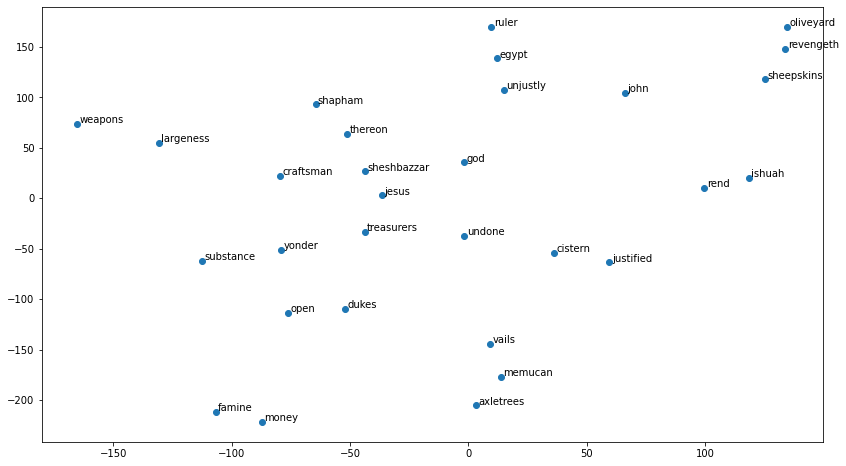

In [ ]:
plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1])
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

## Continuous Bag Of Words (CBOW) model

In [ ]:
import keras.backend as K
from keras.layers import Lambda
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
import gensim

In [ ]:
data=open('/content/data.txt','r')

In [ ]:
corona_data = [text for text in data if text.count(' ') >= 2]
vectorize = Tokenizer()
vectorize.fit_on_texts(corona_data)
corona_data = vectorize.texts_to_sequences(corona_data)
total_vocab = sum(len(s) for s in corona_data)
word_count = len(vectorize.word_index) + 1
window_size = 2

In [ ]:
def cbow_model(data, window_size, total_vocab):
    total_length = window_size*2
    for text in data:
        text_len = len(text)
        for idx, word in enumerate(text):
            context_word = []
            target   = []
            begin = idx - window_size
            end = idx + window_size + 1
            context_word.append([text[i] for i in range(begin, end) if 0 <= i < text_len and i != idx])
            target.append(word)
            contextual = sequence.pad_sequences(context_word, total_length=total_length)
            final_target = np_utils.to_categorical(target, total_vocab)
            yield(contextual, final_target)

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=total_vocab, output_dim=100, input_length=window_size*2))
model.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(100,)))
model.add(Dense(total_vocab, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
for i in range(10):
    cost = 0
    for x, y in cbow_model(data, window_size, total_vocab):
        cost += model.train_on_batch(contextual, final_target)
    print(i, cost)

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0


In [ ]:
dimensions=100
vect_file = open('/content/vectors.txt' ,'w')
vect_file.write('{} {}\n'.format(total_vocab,dimensions))

8

In [ ]:
weights = model.get_weights()[0]
for text, i in vectorize.word_index.items():
    final_vec = ' '.join(map(str, list(weights[i, :])))
    vect_file.write('{} {}\n'.format(text, final_vec))
vect_file.close()

In [ ]:
cbow_output = gensim.models.KeyedVectors.load_word2vec_format('/content/vectors.txt', binary=False)
cbow_output.most_similar(positive=['virus'])

#### Which model is better?

**It depends on the problem!**

*   **Skip-Gram works well with small datasets, and can better represent rare words.**

Is it important for our model to represent less frequent words? then we should choose Skip-Gram.

*   **CBOW is found to train faster than Skip-Gram, and can better represent more frequent words.**

What if we dont have much time to train and rare words are not that important for our solution? Then we should choose CBOW.

## TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer

In [ ]:
dataset = [
    "In order to see the full power of TF-IDF we would actually require a proper, larger dataset.",
    "But for the purpose of our article, we only want to focus on implementation.",
    "So let’s import our dependencies into our project and build our mini-dataset."
    ]

In [ ]:
tfIdfVectorizer=TfidfVectorizer(use_idf=True)
tfIdf = tfIdfVectorizer.fit_transform(dataset)
df = pd.DataFrame(tfIdf[0].T.todense(), index=tfIdfVectorizer.get_feature_names(), columns=["TF-IDF"])
df = df.sort_values('TF-IDF', ascending=False)
print (df.head(25))

In [ ]:
tfIdfTransformer = TfidfTransformer(use_idf=True)
countVectorizer = CountVectorizer()
wordCount = countVectorizer.fit_transform(dataset)
newTfIdf = tfIdfTransformer.fit_transform(wordCount)
df = pd.DataFrame(newTfIdf[0].T.todense(), index=countVectorizer.get_feature_names(), columns=["TF-IDF"])
df = df.sort_values('TF-IDF', ascending=False)
print (df.head(25))

                  TF-IDF
actually        0.259133
idf             0.259133
tf              0.259133
see             0.259133
require         0.259133
proper          0.259133
power           0.259133
order           0.259133
larger          0.259133
in              0.259133
would           0.259133
full            0.259133
of              0.197078
we              0.197078
to              0.197078
the             0.197078
dataset         0.197078
project         0.000000
want            0.000000
article         0.000000
so              0.000000
build           0.000000
but             0.000000
purpose         0.000000
implementation  0.000000


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Also see:

[word2vec tutorial](https://www.tensorflow.org/tutorials/text/word2vec)

[TF-IDF demo](https://remykarem.github.io/tfidf-demo/)